In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load video
cap = cv2.VideoCapture("C:\\Users\\barat\\Downloads\\vide.mp4")
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Get the first frame
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect feature points
feature_params = dict(maxCorners=50, qualityLevel=0.3, minDistance=7, blockSize=7)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Lucas-Kanade parameters
lk_params = dict(winSize=(15, 15), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create mask for drawing
mask = np.zeros_like(old_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = map(int, new.ravel())
            c, d = map(int, old.ravel())
            mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)

    # Overlay mask on frame
    img = cv2.add(frame, mask)

    # Resize for display
    scale_percent = 50  # Resize to 50%
    width = int(img.shape[1] * scale_percent / 50)
    height = int(img.shape[0] * scale_percent / 50)
    img_resized = cv2.resize(img, (width, height))

    cv2.imshow("Optical Flow - Lucas Kanade", img_resized)

    # Update frame
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(30) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


<function matplotlib.pyplot.show(close=None, block=None)>

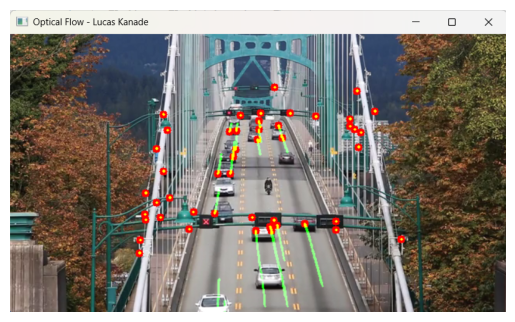

In [10]:
image = cv2.imread(r"C:\Users\barat\Downloads\Screenshot 2025-04-19 130720.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image_rgb)
plt.show

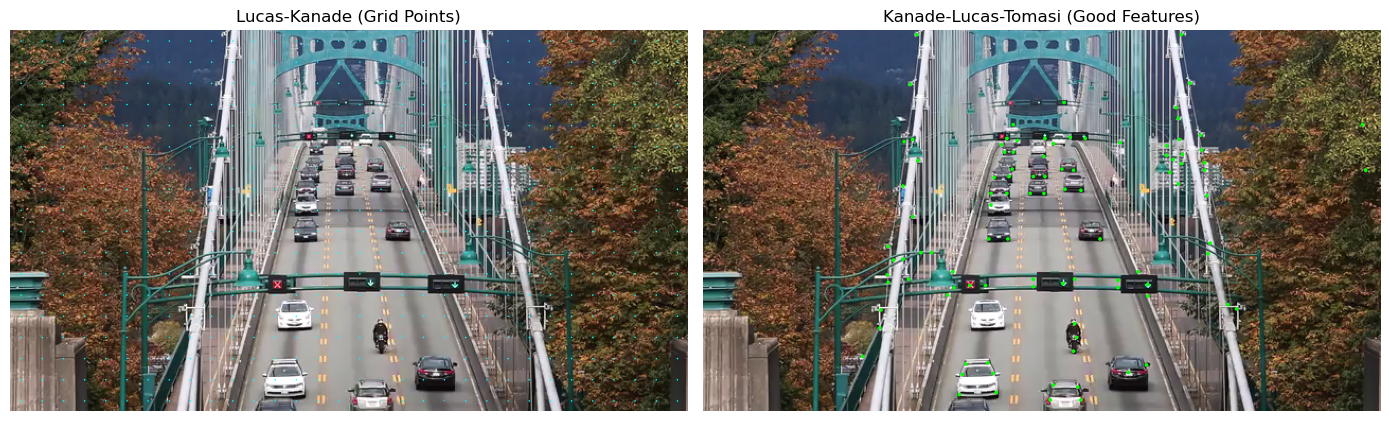

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load video
cap = cv2.VideoCapture("C:\\Users\\barat\\Downloads\\vide.mp4")

# Read first frame
ret, first_frame = cap.read()
gray_prev = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# ----- Lucas-Kanade Setup (Grid Points) -----
step = 20  # Distance between points
h, w = gray_prev.shape
grid_y, grid_x = np.mgrid[step//2:h:step, step//2:w:step]
lk_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T.astype(np.float32).reshape(-1, 1, 2)

# ----- KLT Setup (Good Features) -----
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
klt_points = cv2.goodFeaturesToTrack(gray_prev, mask=None, **feature_params)

# Optical flow params (same for both)
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read second frame
ret, next_frame = cap.read()
gray_next = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

# ----- Apply Lucas-Kanade -----
lk_next, st_lk, _ = cv2.calcOpticalFlowPyrLK(gray_prev, gray_next, lk_points, None, **lk_params)
lk_good_old = lk_points[st_lk == 1]
lk_good_new = lk_next[st_lk == 1]

# ----- Apply KLT Tracker -----
klt_next, st_klt, _ = cv2.calcOpticalFlowPyrLK(gray_prev, gray_next, klt_points, None, **lk_params)
klt_good_old = klt_points[st_klt == 1]
klt_good_new = klt_next[st_klt == 1]

# ----- Plotting Side-by-Side -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
axs[0].quiver(lk_good_old[:, 0], lk_good_old[:, 1],
              lk_good_new[:, 0] - lk_good_old[:, 0],
              lk_good_new[:, 1] - lk_good_old[:, 1],
              angles='xy', scale_units='xy', scale=1, color='cyan')
axs[0].set_title("Lucas-Kanade (Grid Points)")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
axs[1].quiver(klt_good_old[:, 0], klt_good_old[:, 1],
              klt_good_new[:, 0] - klt_good_old[:, 0],
              klt_good_new[:, 1] - klt_good_old[:, 1],
              angles='xy', scale_units='xy', scale=1, color='lime')
axs[1].set_title("Kanade-Lucas-Tomasi (Good Features)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

cap.release()
